## Topics:

- Pytorch on MINST dataset
- Applying BatchNorm, Dropout

In [1]:

from sklearn import datasets
from sklearn.model_selection import train_test_split

import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix
import gc

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.nn as nn
from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [56]:
# Global variables
inpDir = '../input' # Input Stored here
outDir = './ouput' # output Here
modelDir = './models'# to save Models
subDir = 'fashion_mnist' # sub dir by dataset

RANDOM_STATE = 24
np.random.RandomState(seed=RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
rng = np.random.default_rng(seed=RANDOM_STATE)
N_SAMPLE = 1000
ALPHA = 0.001 # LEARNING RATE
TEST_SIZE = 0.2 # 18147 - 56*256
EPOCH = 10 #2200
BATCH_SIZE = 256
LR_FACTOR = 0.1
LR_PATIENCE = 7

In [57]:
# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'medium',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium',
          'savefig.dpi': 300,
          'image.cmap': plt.cm.inferno,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 2,
          'legend.numpoints' : 1
         }

plt.rcParams.update(params)
# To control the display of floating-point numbers when printing arrays. 
np.set_printoptions(precision=3,  # number of decimal places displayed
                    suppress=True) # prevents the use of scientific notation for small numbers
CMAP = plt.cm.coolwarm
# number of columns displayed when printing a DataFrame
pd.set_option("display.max_columns", 8) # maximum number of columns that will be displayed at once
pd.set_option('display.precision', 2) # precision for floating-point numbers when it’s displayed
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

### loading fashion MNIST dataset(it contains 70000 images and 10 labels)

In [58]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
train_df = pd.read_csv(train_filename, header = 0)

test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')
test_df = pd.read_csv(test_filename, header = 0)

In [59]:
train_df.head()

,label,pixel1,pixel2,pixel3,...,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,...,0,0,0,0
1,9,0,0,0,...,0,0,0,0
2,6,0,0,0,...,0,0,0,0
3,0,0,0,0,...,0,0,0,0
4,3,0,0,0,...,0,0,0,0


In [60]:
# train_df = pd.read_csv(r"C:\Users\DAI.STUDENTSDC\PycharmProjects\pythonProject1\deep learning\day4\fashion-mnist_train.csv", header=0)
# train_df.head()

In [61]:
# test_df = pd.read_csv(r"C:\Users\DAI.STUDENTSDC\PycharmProjects\pythonProject1\deep learning\day4\fashion-mnist_test.csv", header=0)
# test_df.head()

In [62]:
train_df.isnull().sum().sum()

np.int64(0)

In [63]:
# setting the class names of the labels in the dataset
class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

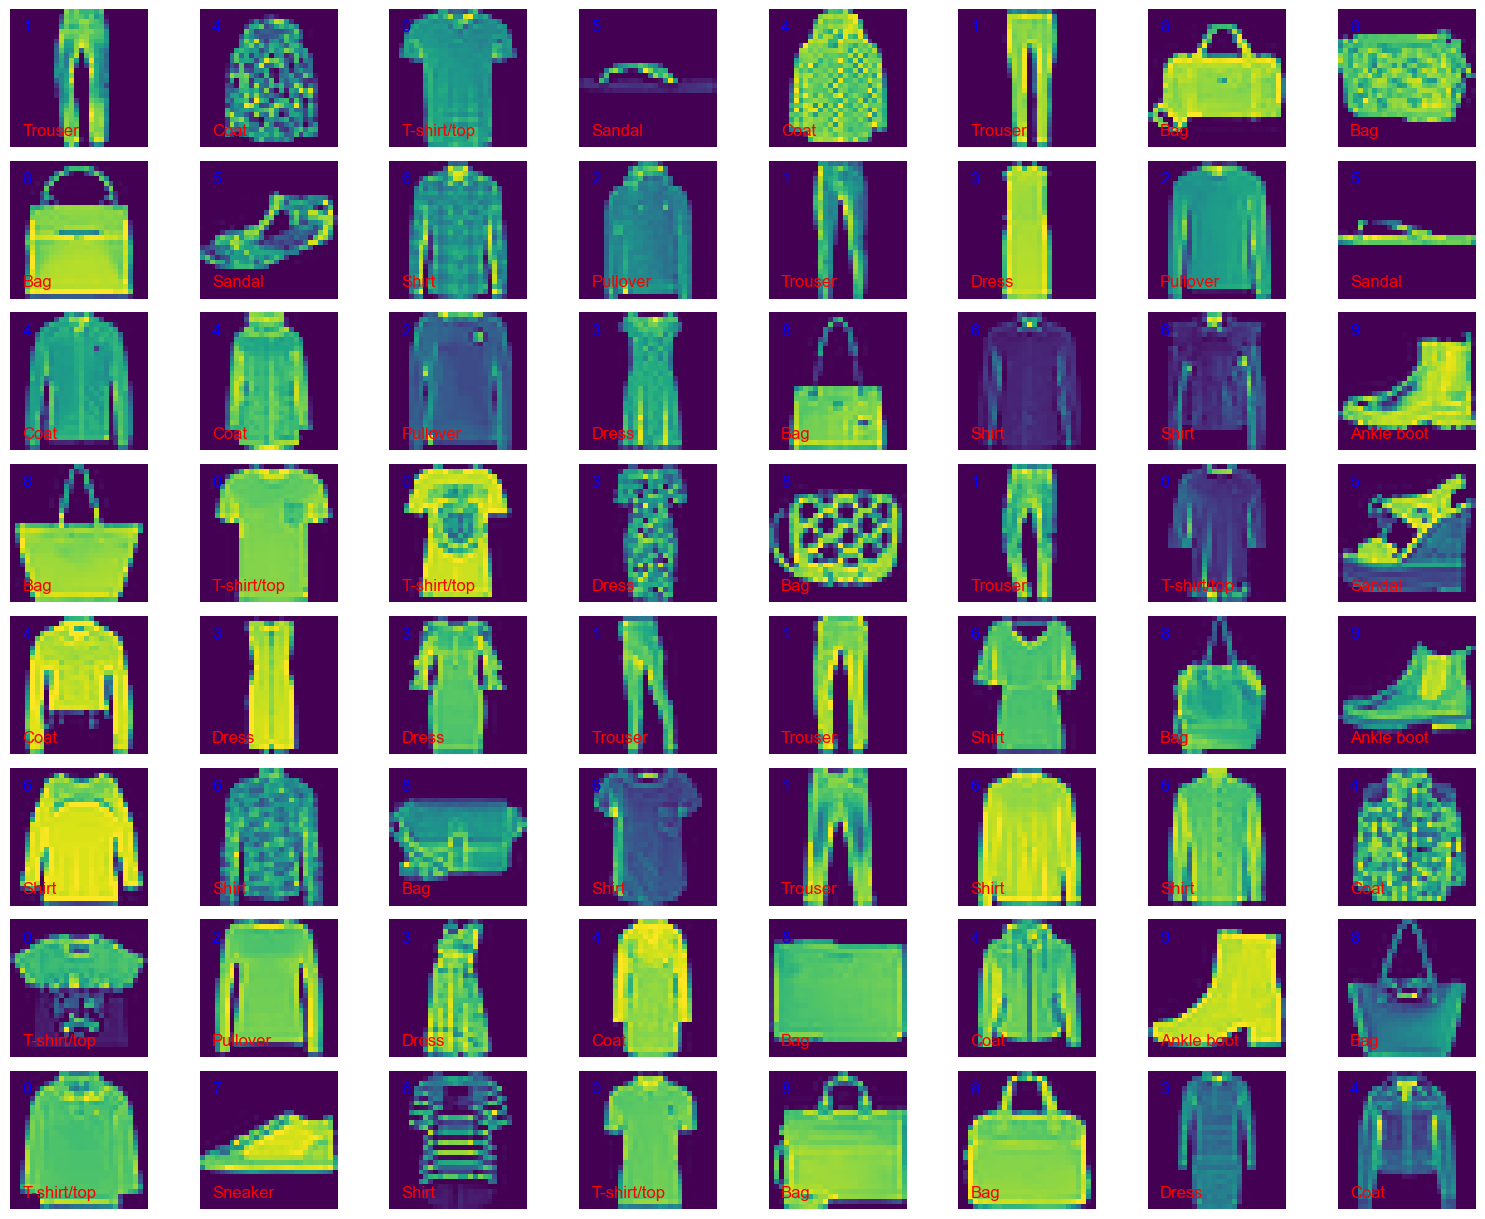

In [64]:
# displaying a grid of images from the dataset along with the labels
n_rows = 8  # Number of rows in the grid
n_cols = 8  # Number of columns

# Randomly sample images from the dataset
plot_df = train_df.sample(n=n_rows * n_cols)

# Create a figure for the image grid
fig = plt.figure(figsize=(15, 12))

# Adjust subplot margins and spacing
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.1, wspace=0.1)

# Loop through each sampled image and display it
for i, (idx, row) in enumerate(plot_df.iterrows(), 1):
    image = row.values[1:].reshape(28, 28)  # Adjust based on column indexing
    ax = fig.add_subplot(n_rows, n_cols, i, xticks=[], yticks=[])
    
    # Display the image
    ax.imshow(image, cmap=plt.cm.viridis, interpolation='nearest')
    
    # Add the label and class name
    ax.text(2, 4, str(row.iloc[0]), color='blue', fontsize=12)
    ax.text(2, 25, class_names[row.iloc[0]], color='red', fontsize=12)

# Show the grid
plt.show()

In [65]:
plot_df.shape

(64, 785)

In [66]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [67]:
X_train = train_df.drop('label',axis=1).to_numpy()
y_train = train_df['label'].to_numpy()

In [68]:
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [69]:
# # now making the validation datasets
X_valid = test_df.drop('label', axis=1).to_numpy()
y_valid = test_df['label'].to_numpy()

In [70]:
# ### Preprocessing and batching
# # Add an extra dimension to `train_y` to match `train_X`'s rank for concatenation
# train_y_expanded = train_y.unsqueeze(1)  # Shape: (num_samples, 1)
# # Concatenate `train_X` and `train_y` along the last dimension
# train_ds = torch.cat((train_X, train_y_expanded), dim=1)

# # Add an extra dimension to `test_y` to match `test_X`'s rank for concatenation
# test_y_expanded = test_y.unsqueeze(1)  # Shape: (num_samples, 1)
# # Concatenate `test_X` and `test_y` along the last dimension
# test_ds = torch.cat((test_X, test_y_expanded), dim=1)

# valid_y_expanded = valid_y.unsqueeze(1)
# valid_ds = torch.cat((valid_X, valid_y_expanded), dim=1)



In [71]:
# train_ds.shape

In [72]:
# test_ds.shape

In [73]:
# valid_ds.shape

In [74]:
# train_shape = X_train.shape
# test_shape = X_test.shape
# valid_shape = X_valid.shape

In [75]:
 #pytorch model setup(Class based)
dor1, dor2, dor3, dor4, dor5 = 0, 0.1, 0.4, 0.2, 0.1
input_dim = X_train.shape[1]
# instantiate the model
class Model(nn.Module):
    
    def __init__(self,input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 392)
        self.bnl1 = nn.BatchNorm1d(392)  # Batch normalization for layer1
        self.actv1 = nn.ReLU()
        self.drop1 = nn.Dropout(dor1)

        self.layer2 = nn.Linear(392, 196)
        self.bnl2 = nn.BatchNorm1d(196)  # Batch normalization for layer2
        self.actv2 = nn.ReLU()
        self.drop2 = nn.Dropout(dor2)

        self.layer3 = nn.Linear(196, 98)
        self.bnl3 = nn.BatchNorm1d(98)  # Batch normalization for layer3
        self.actv3 = nn.ReLU()
        self.drop3 = nn.Dropout(dor3)

        self.layer4 = nn.Linear(98, 49)
        self.bnl4 = nn.BatchNorm1d(49) # batch normalization for layer4
        self.actv4 = nn.ReLU()
        self.drop4 = nn.Dropout(dor4)

        self.layer5 = nn.Linear(49, 24)
        self.bnl5 = nn.BatchNorm1d(24) # batch normalization for layer5
        self.actv5 = nn.ReLU()
        self.drop5 = nn.Dropout(dor5)

        self.layer6 = nn.Linear(24, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.bnl1(x)
        x = self.actv1(x)
        x = self.drop1(x)

        x = self.layer2(x)
        x = self.bnl2(x)
        x = self.actv2(x)
        x = self.drop2(x)
        
        x = self.layer3(x)
        x = self.bnl3(x)
        x = self.actv3(x)
        x = self.drop3(x)

        x = self.layer4(x)
        x = self.bnl4(x)
        x = self.actv4(x)
        x = self.drop4(x)

        x = self.layer5(x)
        x = self.bnl5(x)
        x = self.actv5(x)
        x = self.drop5(x)

        x = self.layer6(x)
        return x

model = Model(input_dim).to(device=device)
model
        



Model(
  (layer1): Linear(in_features=784, out_features=392, bias=True)
  (bnl1): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv1): ReLU()
  (drop1): Dropout(p=0, inplace=False)
  (layer2): Linear(in_features=392, out_features=196, bias=True)
  (bnl2): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv2): ReLU()
  (drop2): Dropout(p=0.1, inplace=False)
  (layer3): Linear(in_features=196, out_features=98, bias=True)
  (bnl3): BatchNorm1d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv3): ReLU()
  (drop3): Dropout(p=0.4, inplace=False)
  (layer4): Linear(in_features=98, out_features=49, bias=True)
  (bnl4): BatchNorm1d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv4): ReLU()
  (drop4): Dropout(p=0.2, inplace=False)
  (layer5): Linear(in_features=49, out_features=24, bias=True)
  (bnl5): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running

In [76]:
for param in list(model.parameters()):
    display(param.shape)

torch.Size([392, 784])

torch.Size([392])

torch.Size([392])

torch.Size([392])

torch.Size([196, 392])

torch.Size([196])

torch.Size([196])

torch.Size([196])

torch.Size([98, 196])

torch.Size([98])

torch.Size([98])

torch.Size([98])

torch.Size([49, 98])

torch.Size([49])

torch.Size([49])

torch.Size([49])

torch.Size([24, 49])

torch.Size([24])

torch.Size([24])

torch.Size([24])

torch.Size([10, 24])

torch.Size([10])

In [77]:
# conversion to torch custom dataset
class MNISTDataset(Dataset):
    def __init__(self, X, y):
        super(MNISTDataset,self).__init__() # initializes the constructor of the superclass of FifaDataset ==> (Dataset)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self): # returns the number of rows in the dataset
        return len(self.X)

    def __getitem__(self,idx): # getting the indices of the item in the dataset
        return self.X[idx], self.y[idx]    

In [78]:
# training data to custom dataset
train_dataset = MNISTDataset(X_train, y_train)
train_dataset

In [79]:
# using DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
X_batch, y_batch = next(iter(train_loader))
X_batch.shape, y_batch.shape

(torch.Size([256, 784]), torch.Size([256]))

In [80]:
# testing data to custom dataset
valid_dataset = MNISTDataset(X_valid, y_valid)
valid_dataset

In [81]:
test_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=True) 
X_batch, y_batch = next(iter(test_loader))
X_batch.shape, y_batch.shape

(torch.Size([256, 784]), torch.Size([256]))

In [82]:
# numpy array to tensor conversion. These tensors are then moved to the the device mentioned above
train_X = torch.tensor(X_train, dtype=torch.float32, device=device) # these datatypes are the standard for such conversions
train_y = torch.tensor(y_train, dtype=torch.int64, device=device)
valid_X = torch.tensor(X_valid, dtype=torch.float32, device=device)
valid_y = torch.tensor(y_valid, dtype=torch.float32, device=device)

In [83]:
# EPOCH = 30

In [84]:
# Model training and fitting, with batches
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_FACTOR, patience =LR_PATIENCE)
# Metrics tracking
loss, tloss, acc, tacc, n_epoch = [], [], [], [], []
best_loss = np.inf

# Training loop
for epoch in range(EPOCH):
    epoch_loss = 0
    epoch_acc = 0
    tepoch_loss = 0
    tepoch_acc = 0 
    # Training phase
    model.train()
    for batch_idx , (train_X, train_y) in enumerate(train_loader):
        train_X = train_X.to(device)
        train_y = train_y.to(device)
        predict_proba = model(train_X) # make predictions
        batch_loss = loss_fn(predict_proba, train_y) # calculate batch loss
        epoch_loss += (batch_loss - epoch_loss)/(batch_idx+1) # average of batch losses till now(running)

        # Backpropagation phase
        optimizer.zero_grad(set_to_none=True)  # Clear gradients
        batch_loss.backward()  # Calculate Loss gradient and propagate it backwards
        optimizer.step()  # Update parameters

        y_pred = predict_proba.argmax(dim=1).cpu().numpy()
        batch_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
        epoch_acc += (batch_acc - epoch_acc)/(batch_idx+1) # average of batch accuracies till now
    

    loss.append(epoch_loss.data.item())  # Store training loss for this epoch
    acc.append(epoch_acc)  # Store training accuracy for this epoch

    # Validation phase
    model.eval()
    for batch_idx, (valid_X, valid_y) in enumerate(test_loader):
        with torch.no_grad():  # Disable gradient computation
            valid_X = valid_X.to(device)
            valid_y = valid_y.to(device)
            valid_proba = model(valid_X) # make a prediction
            batch_loss = loss_fn(valid_proba, valid_y) # calculate loss
            tepoch_loss += (batch_loss - tepoch_loss)/(batch_idx+1)  # average of batch losses till now

            y_pred = valid_proba.argmax(dim=1).cpu().numpy()
            batch_acc = accuracy_score(valid_y.cpu().numpy(), y_pred)
            tepoch_acc += (batch_acc - tepoch_acc)/(batch_idx+1) # Running mean of accuracies
    
    tacc.append(tepoch_acc)
    tloss.append(tepoch_loss.data.item()) # picking out the item from the data in the tensor
    n_epoch.append(epoch) # appending epoch numbers
    scheduler.step(tepoch_loss)
    # Logging progress
    print(f"Epoch {epoch + 1}/{EPOCH}, Loss: {epoch_loss:.4f}/{tepoch_loss:.4f}, "
          f"Acc: {epoch_acc:.4f}/{tepoch_acc:.4f}")

Epoch 1/10, Loss: 0.9930/0.4949, Acc: 0.7586/0.8475
Epoch 2/10, Loss: 0.4913/0.4183, Acc: 0.8527/0.8524
Epoch 3/10, Loss: 0.4204/0.4013, Acc: 0.8652/0.8618
Epoch 4/10, Loss: 0.3765/0.3379, Acc: 0.8774/0.8824
Epoch 5/10, Loss: 0.3515/0.3419, Acc: 0.8836/0.8721
Epoch 6/10, Loss: 0.3320/0.3581, Acc: 0.8910/0.8762
Epoch 7/10, Loss: 0.3143/0.3422, Acc: 0.8967/0.8820
Epoch 8/10, Loss: 0.2990/0.3043, Acc: 0.9020/0.8945
Epoch 9/10, Loss: 0.2834/0.3312, Acc: 0.9070/0.8828
Epoch 10/10, Loss: 0.2751/0.3578, Acc: 0.9091/0.8717


In [85]:
modelPath = os.path.join(modelDir, subDir, f'torch_{subDir}_{torch.version.cuda}.pth')
modelPath

'./models\\fashion_mnist\\torch_fashion_mnist_None.pth'

In [86]:
tepoch_loss, best_loss

(tensor(0.3578), inf)

In [87]:

# Saving model
if tepoch_loss <= best_loss:
    best_loss = tepoch_loss
    torch.save(model, modelPath)

In [88]:
hist_df = pd.DataFrame({'epoch':n_epoch,
                       'loss':loss, 
                       'test_loss':tloss,
                       'acc':acc,
                       'test_acc':tacc})
hist_df

,epoch,loss,test_loss,acc,test_acc
0,0,0.99,0.49,0.76,0.85
1,1,0.49,0.42,0.85,0.85
2,2,0.42,0.40,0.87,0.86
3,3,0.38,0.34,0.88,0.88
4,4,0.35,0.34,0.88,0.87
5,5,0.33,0.36,0.89,0.88
6,6,0.31,0.34,0.90,0.88
7,7,0.30,0.30,0.90,0.89
8,8,0.28,0.33,0.91,0.88
9,9,0.28,0.36,0.91,0.87


<Axes: xlabel='epoch'>

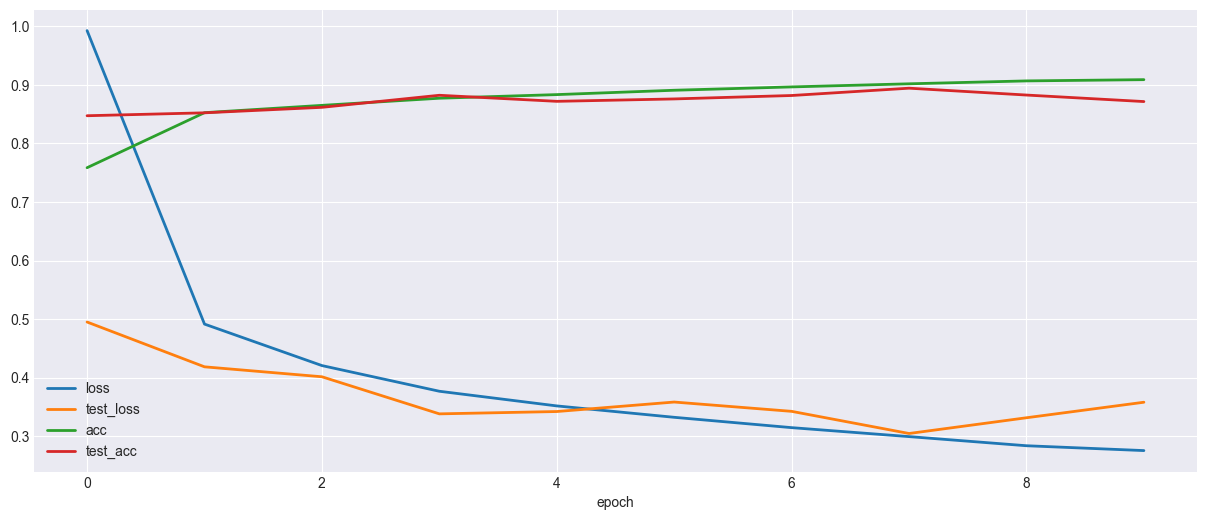

In [89]:
hist_df.plot(x='epoch', y=['loss', 'test_loss', 'acc', 'test_acc'])

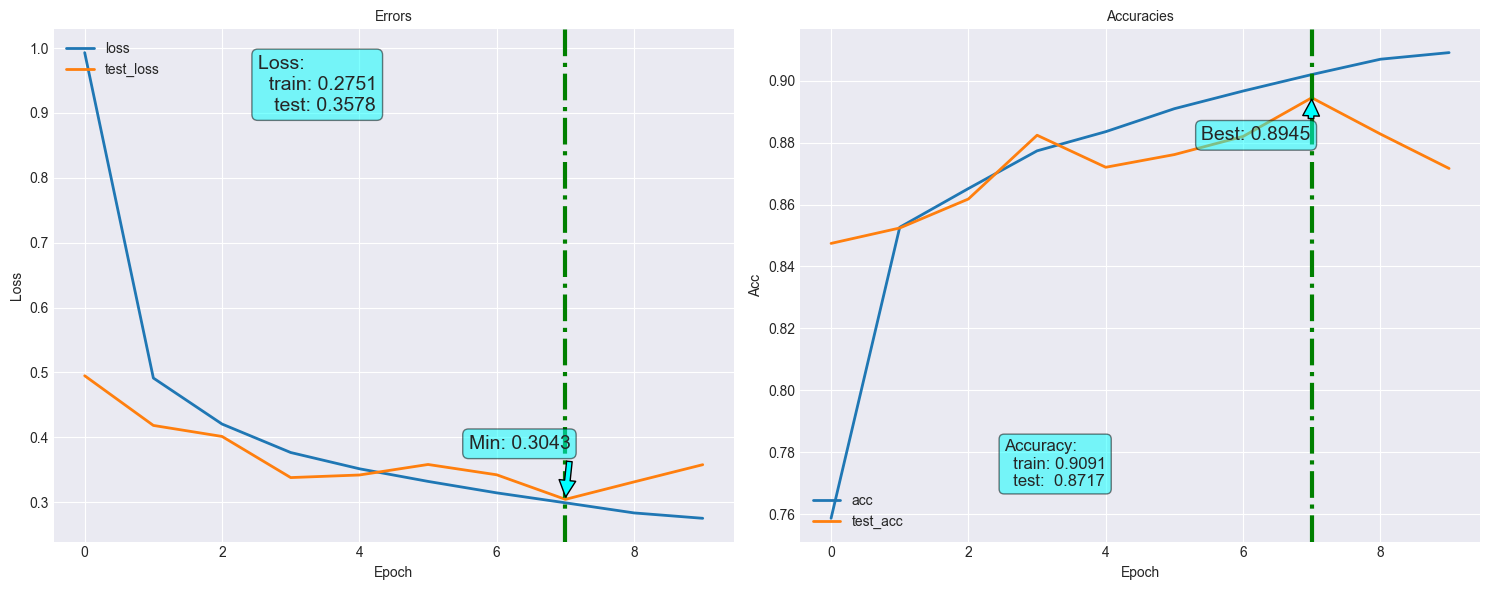

In [90]:
fn_plot_torch_hist(hist_df)

# dropout + regularization
dropouts = 0.1, 0.3, 0.2, 0.3, 0.1
lr_patience = 10

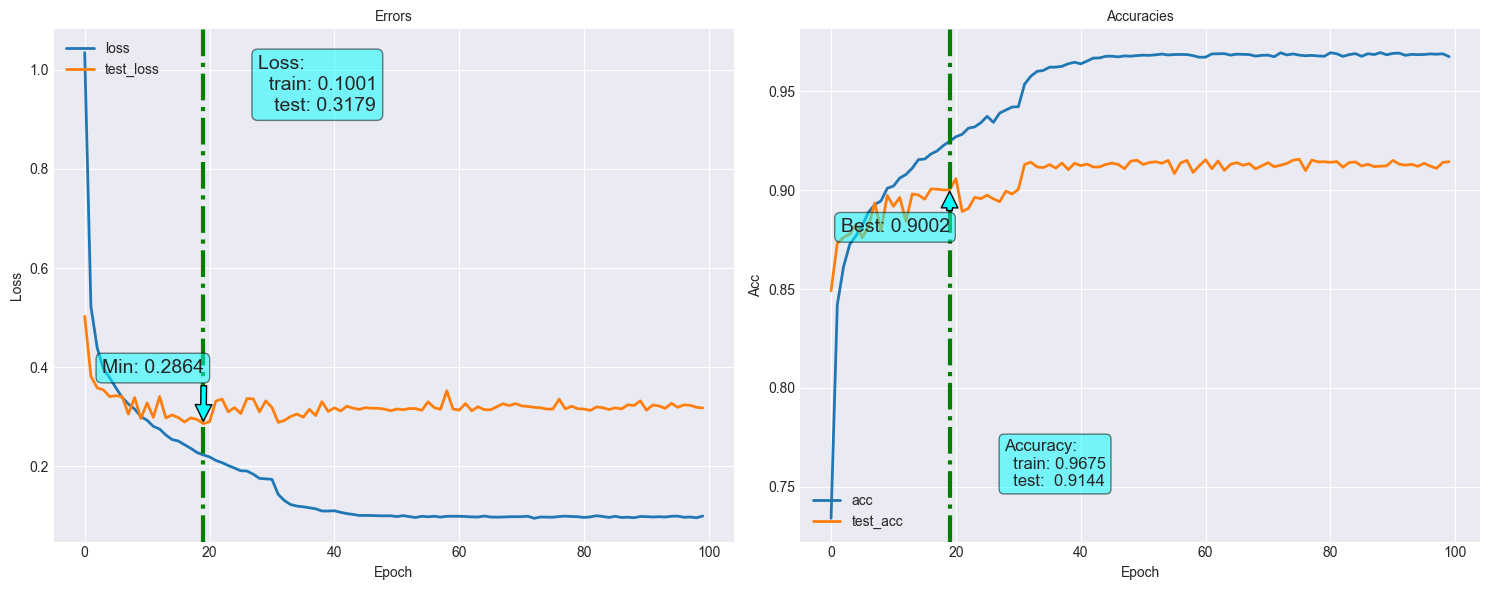

# dropouts  = 0.15, 0.1, 0.1, 0.2, 0.3, lr_patience = 15
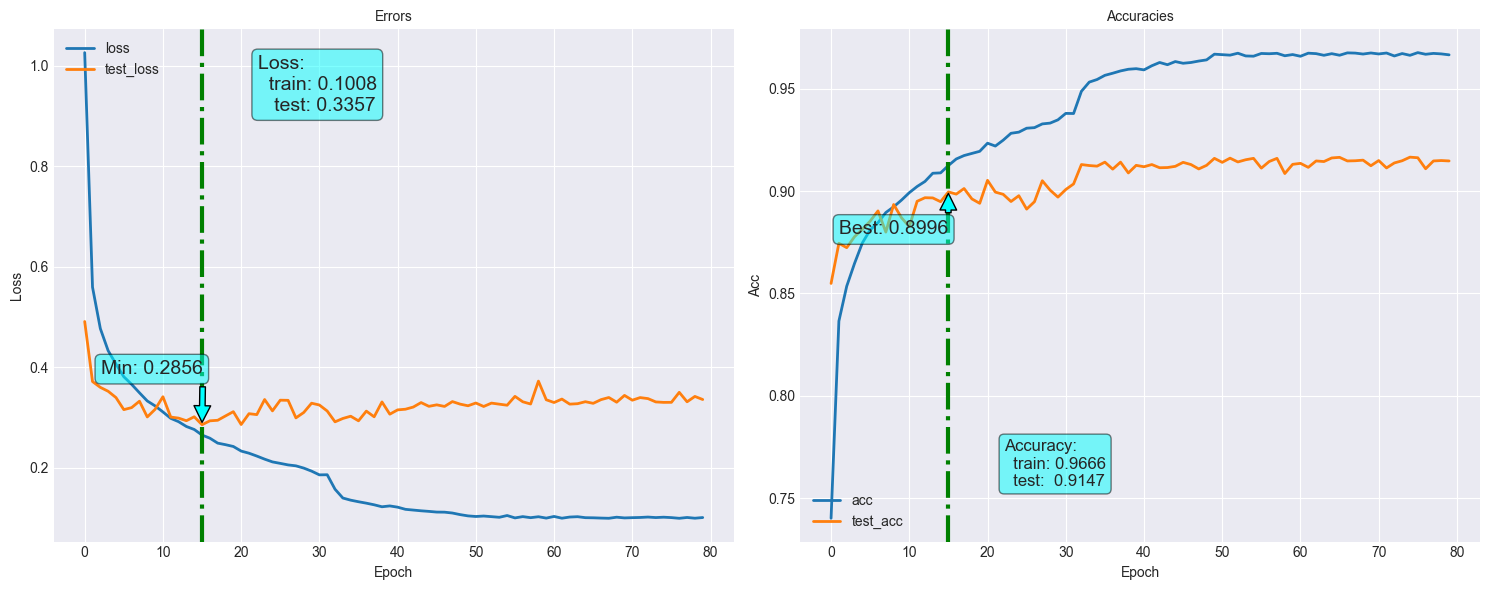

## dropout  = 0.1, 0.1, 0.2, 0.2, 0.3
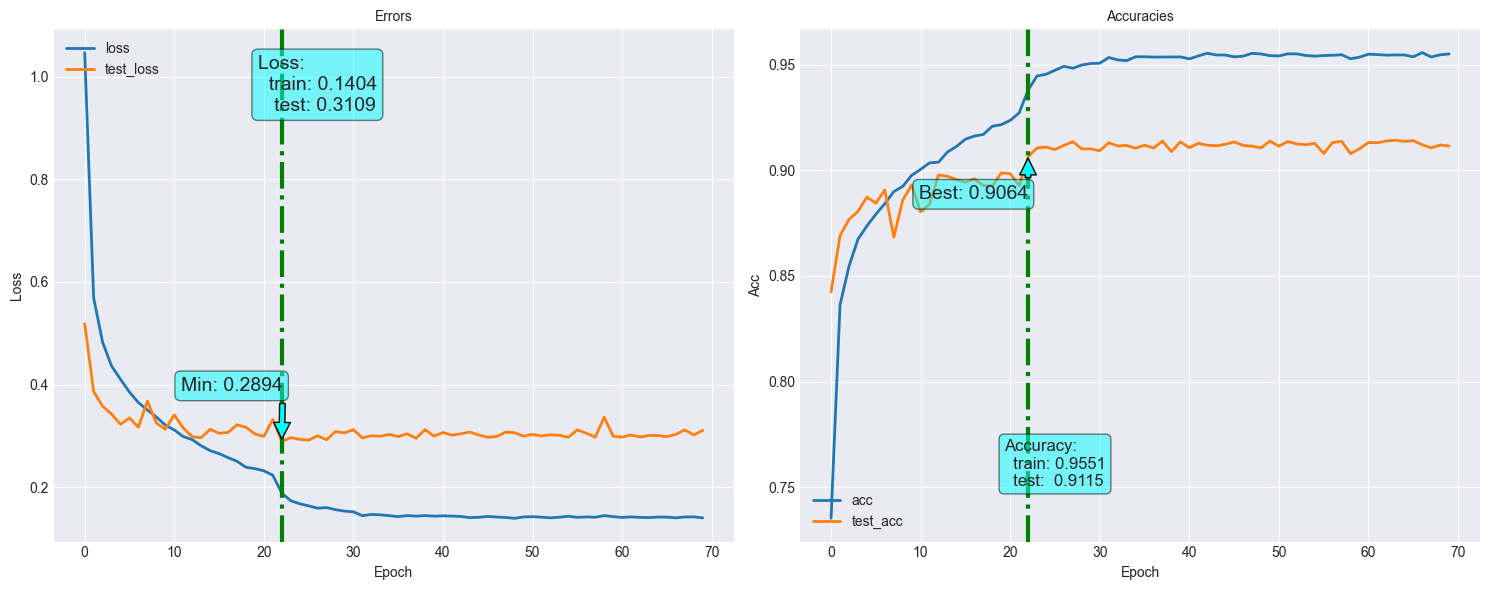

dropouts = 0.1, 0.1, 0.4, 0.2, 0.1 
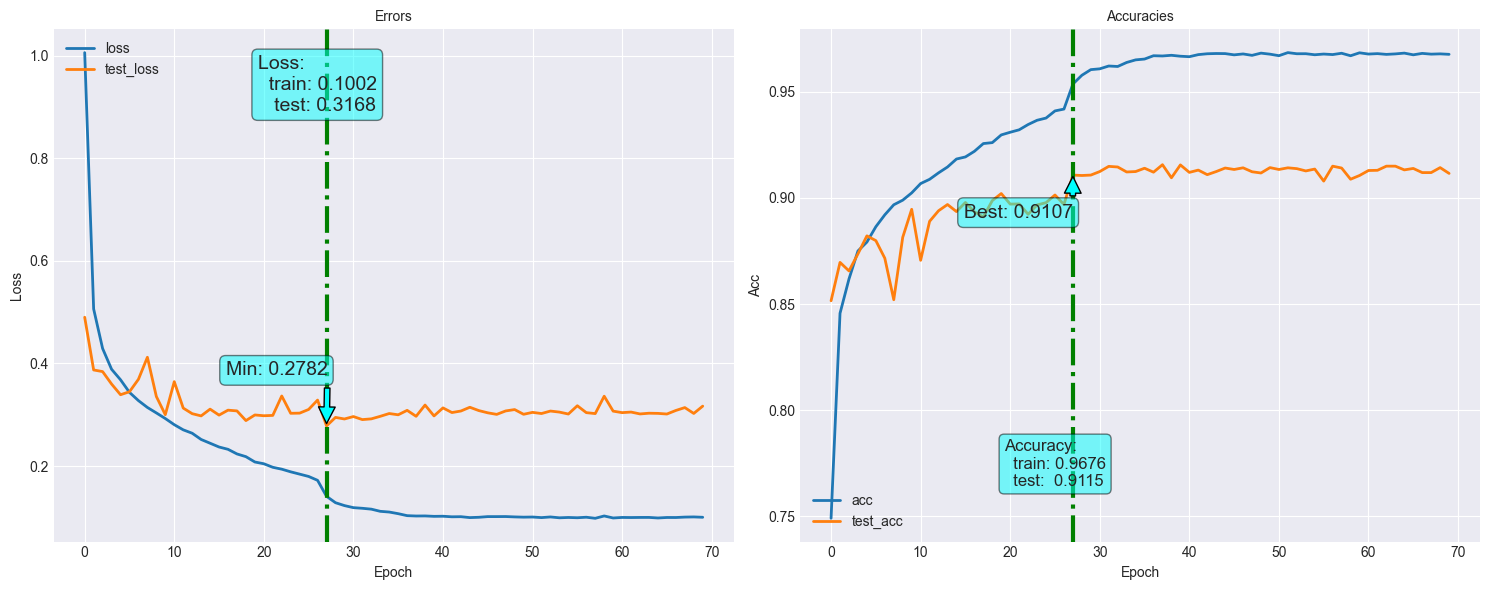

In [91]:
# Assuming model is your trained model
torch.save(model, modelPath)

print(f'Saved file as: {modelPath}')

Saved file as: ./models\fashion_mnist\torch_fashion_mnist_None.pth


In [92]:
del model

In [ ]:
model.eval() # Model Deleted so Error

NameError: name 'model' is not defined

In [ ]:
# Loading model 
model = torch.load(modelPath, weights_only=False)
model.eval()

Model(
  (layer1): Linear(in_features=784, out_features=392, bias=True)
  (bnl1): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv1): ReLU()
  (drop1): Dropout(p=0, inplace=False)
  (layer2): Linear(in_features=392, out_features=196, bias=True)
  (bnl2): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv2): ReLU()
  (drop2): Dropout(p=0.1, inplace=False)
  (layer3): Linear(in_features=196, out_features=98, bias=True)
  (bnl3): BatchNorm1d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv3): ReLU()
  (drop3): Dropout(p=0.4, inplace=False)
  (layer4): Linear(in_features=98, out_features=49, bias=True)
  (bnl4): BatchNorm1d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv4): ReLU()
  (drop4): Dropout(p=0.2, inplace=False)
  (layer5): Linear(in_features=49, out_features=24, bias=True)
  (bnl5): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running